# 1. Libraries

In [3]:
import pandas as pd
import numpy as np
import ast
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.feature_selection import RFECV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
import plotly.graph_objects as go

# 2. Load data  

In [4]:
data = pd.read_csv('/home/nivelrios/documentos/Mburicao Project/src/data/data_extraction.csv')
features_r2 = pd.read_csv('/home/nivelrios/documentos/Mburicao Project/src/evaluation/LR_best_features_r2.csv')
features_rmse = pd.read_csv('/home/nivelrios/documentos/Mburicao Project/src/evaluation/LR_best_features_rmse.csv')
features_mape = pd.read_csv('/home/nivelrios/documentos/Mburicao Project/src/evaluation/LR_best_features_mape.csv')

# 3. Model define

## 3.1 Data selection based the best metrics score

In [5]:
df = data.copy()
df = df.drop(columns=["fecha"])

In [6]:
best_features_r2 = features_r2['best_features'].apply(
    lambda x: list(ast.literal_eval(x)) if isinstance(x, str) else list(x)
).tolist()
best_features_rmse = features_rmse['best_features'].apply(
    lambda x: list(ast.literal_eval(x)) if isinstance(x, str) else list(x)
).tolist()
best_features_mape = features_mape['best_features'].apply(
    lambda x: list(ast.literal_eval(x)) if isinstance(x, str) else list(x)
).tolist()

## 3.2 Features based metrics results

In [9]:
lista_features_r2 = best_features_r2[3]
lista_features_rmse = best_features_rmse[3]
lista_features_mape = best_features_mape[3]

## 3.2.1 LR model based the best R2 metric 

In [30]:
X = df[lista_features_r2]
y = df["global_peak"].values.reshape(-1, 1)
if len(y.shape) == 1:
    y = y.reshape(-1, 1)
scaler_X = MinMaxScaler()  
scaler_y = MinMaxScaler()
X_normalized = scaler_X.fit_transform(X)
y_normalized = scaler_y.fit_transform(y)
model = LinearRegression()
kf = KFold(n_splits=5, shuffle=True, random_state=42) 
y_pred_normalized = cross_val_predict(model, X_normalized, y_normalized, cv=kf)


y_pred = scaler_y.inverse_transform(y_pred_normalized)
y_true = scaler_y.inverse_transform(y_normalized)
r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = mean_absolute_percentage_error(y_true, y_pred)

print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f}")

R² Score: 0.8209
RMSE: 0.3509
MAPE: 0.3127


In [31]:
lista_features_r2

['sil_40', 'sil_60', 'sil_accumulated_60', 'sil_accumulated_70']

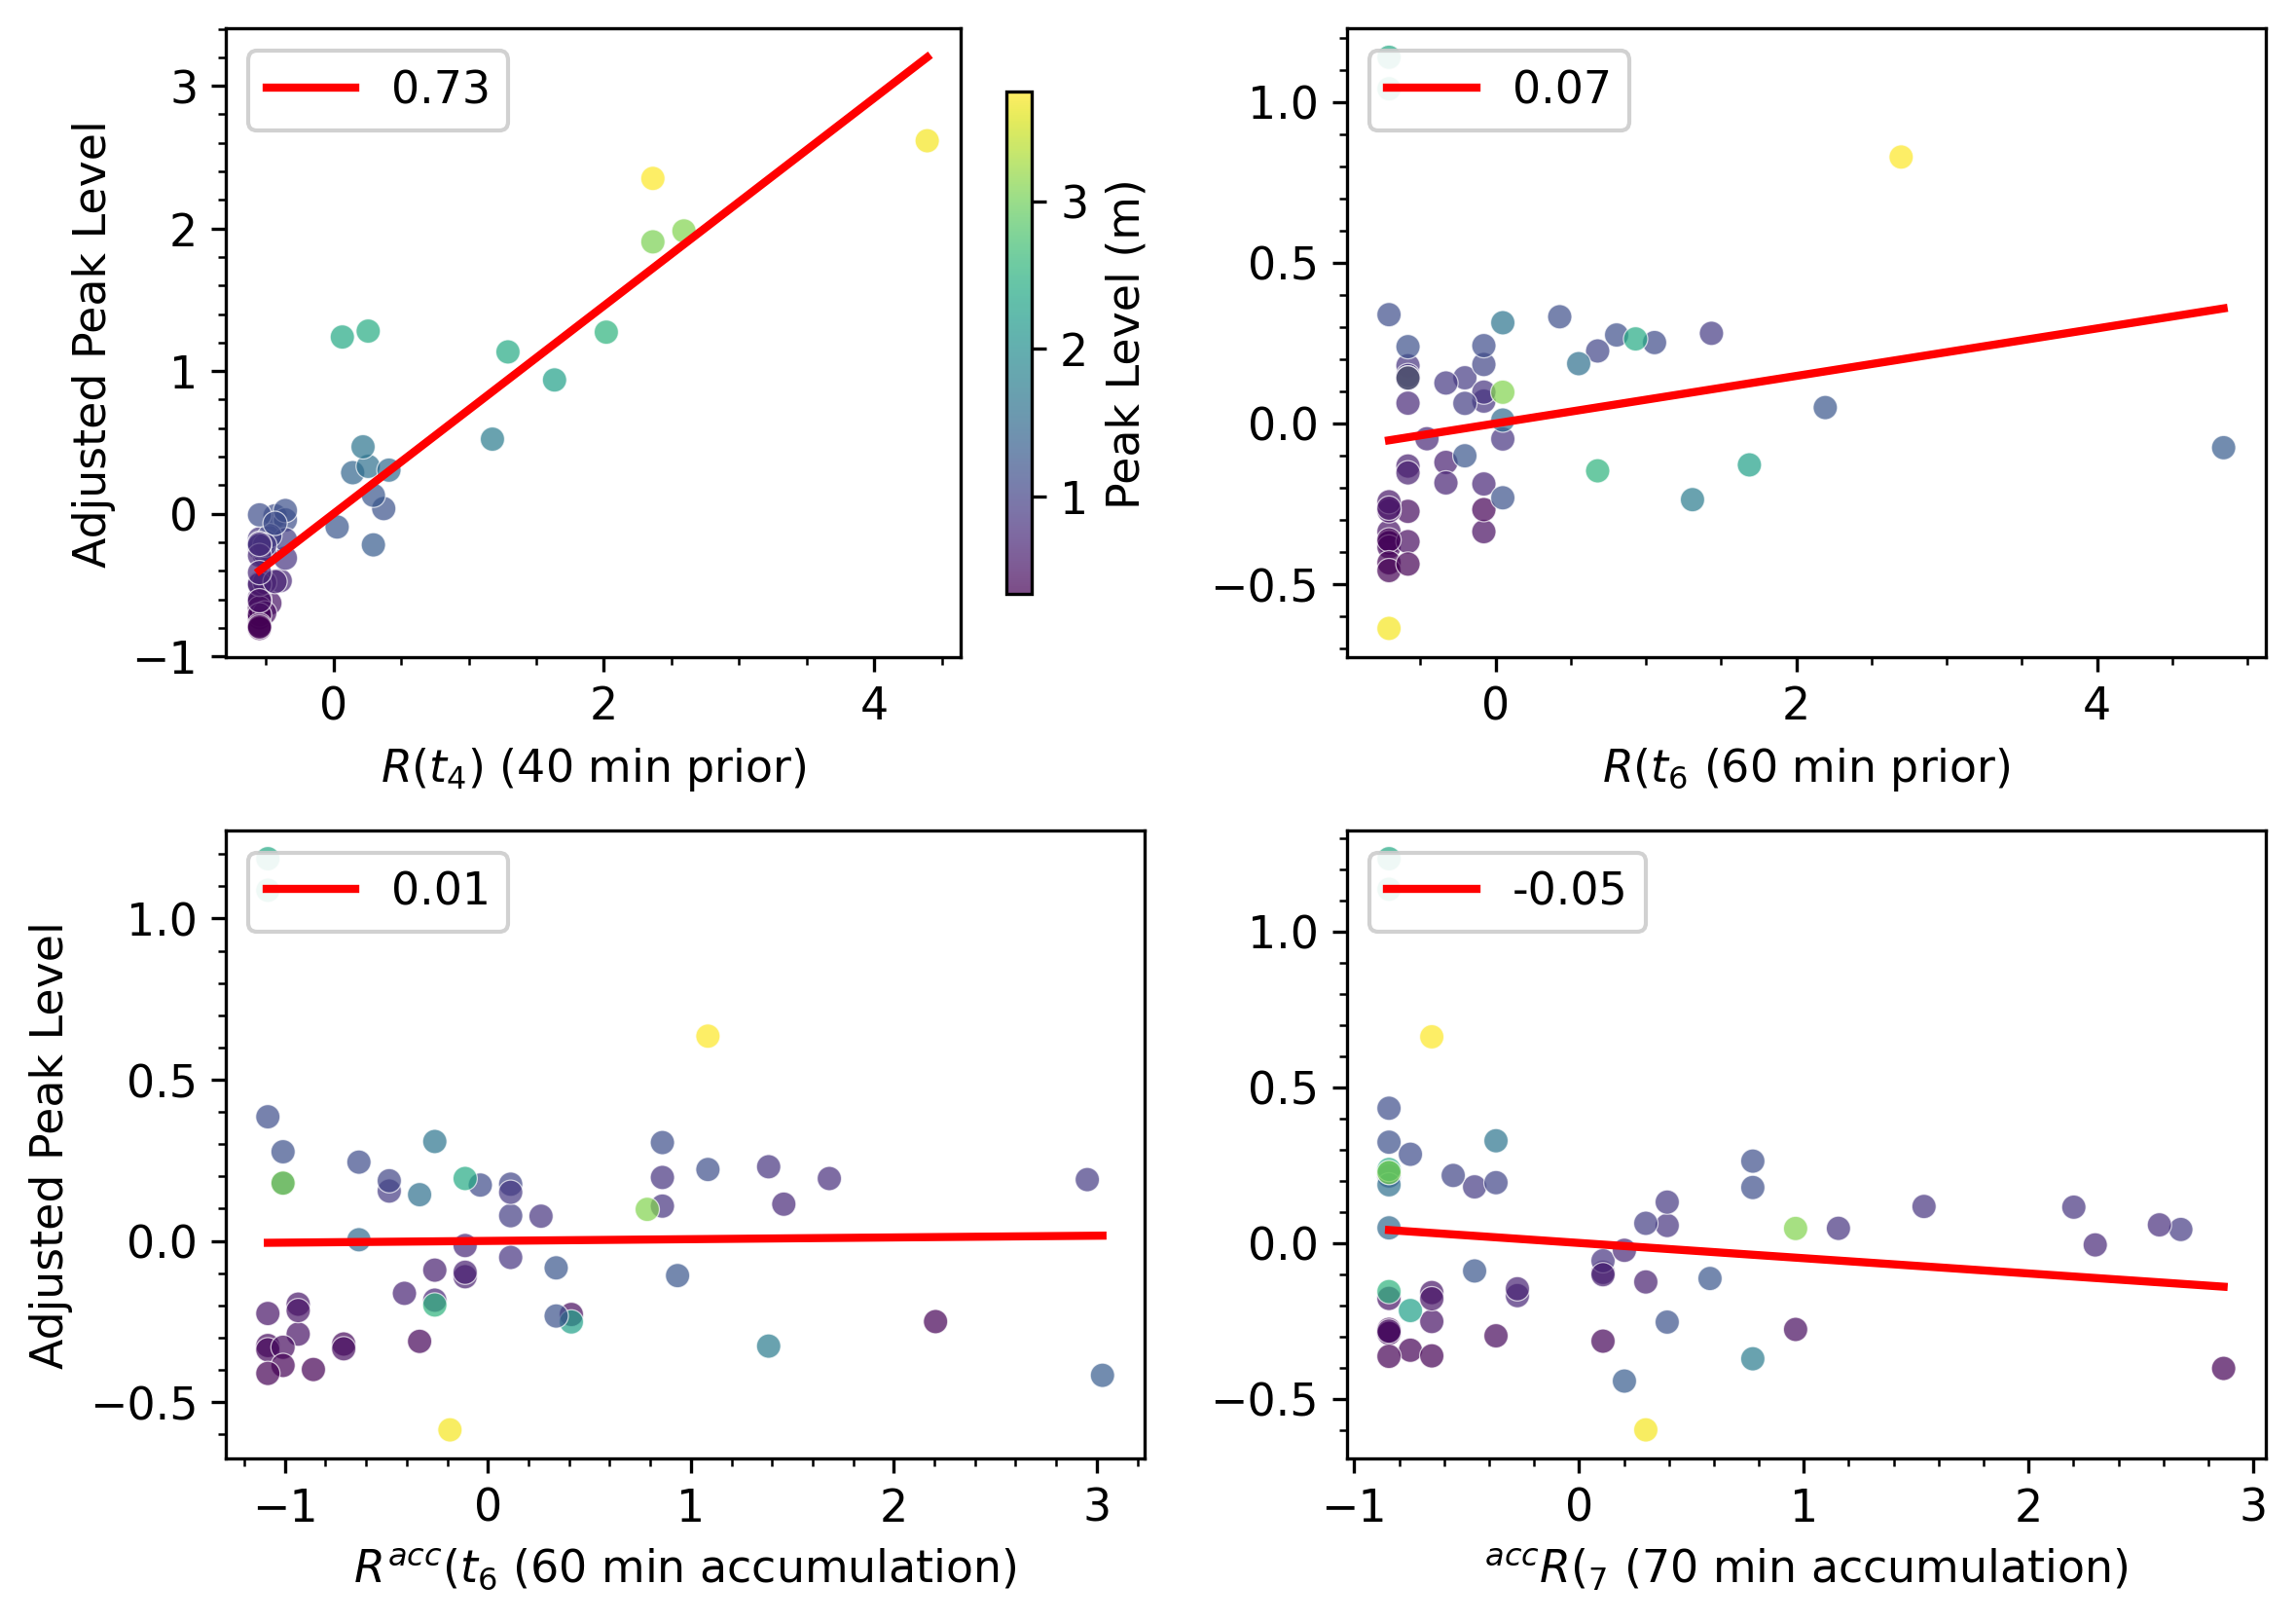

In [45]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import AutoMinorLocator

# Define feature names and labels with improved mathematical notation
feature_labels = {
    'sil_40': r'$R(t_4)$ (40 min prior)',
    'sil_60': r'$R(t_6$ (60 min prior)',
    'sil_accumulated_60': r'$R^{acc}(t_6$ (60 min accumulation)',
    'sil_accumulated_70': r'$^{acc}R(_7$ (70 min accumulation)'
}

# Data preparation
X = df[lista_features_r2].values
y = df["global_peak"].values.reshape(-1, 1)

# Standardize for better coefficient comparison
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Fit full multivariate model
full_model = LinearRegression()
full_model.fit(X_std, y)

# Create figure with professional styling
plt.figure(figsize=(8, 6), dpi=300)
plt.rcParams.update({'font.size': 11, 'font.family': 'DejaVu Sans'})

# 1. Individual feature relationships
for i, feature in enumerate(lista_features_r2):
    ax = plt.subplot(2, 2, i+1)
    
    # Partial regression plot (adjusting for other features)
    x_partial = X_std[:, i].reshape(-1, 1)
    y_residual = y - (full_model.predict(X_std) - full_model.coef_[0][i] * x_partial)
    
    # Fit and plot
    partial_model = LinearRegression()
    partial_model.fit(x_partial, y_residual)
    y_pred_partial = partial_model.predict(x_partial)
    
    # Scatter plot with partial residuals
    sc = ax.scatter(x_partial, y_residual, c=y.flatten(), 
                   cmap='viridis', alpha=0.7, edgecolor='w', linewidth=0.3,
                   vmin=y.min(), vmax=y.max())
    
    # Regression line
    x_plot = np.linspace(x_partial.min(), x_partial.max(), 100)
    ax.plot(x_plot, partial_model.predict(x_plot.reshape(-1, 1)), 
            'r-', lw=2, label=f'{partial_model.coef_[0][0]:.2f}')
    
    # Formatting
    ax.set_xlabel(feature_labels[feature])
    ax.set_ylabel('Adjusted Peak Level' if i%2==0 else '')
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    #ax.grid(which='both', alpha=0.2)
    ax.legend(loc='upper left', framealpha=0.9)
    
    # Add colorbar to first plot
    if i == 0:
        cbar = plt.colorbar(sc, ax=ax, shrink=0.8)
        cbar.set_label('Peak Level (m)')

# Final adjustments
plt.tight_layout()
plt.subplots_adjust(top=0.92)
#plt.suptitle("Multilinear Regression Analysis of Peak Level Predictors", y=0.98, fontsize=13)

plt.savefig("Multilinear_Regression_Analysis.png", dpi=300, bbox_inches='tight')
plt.show()

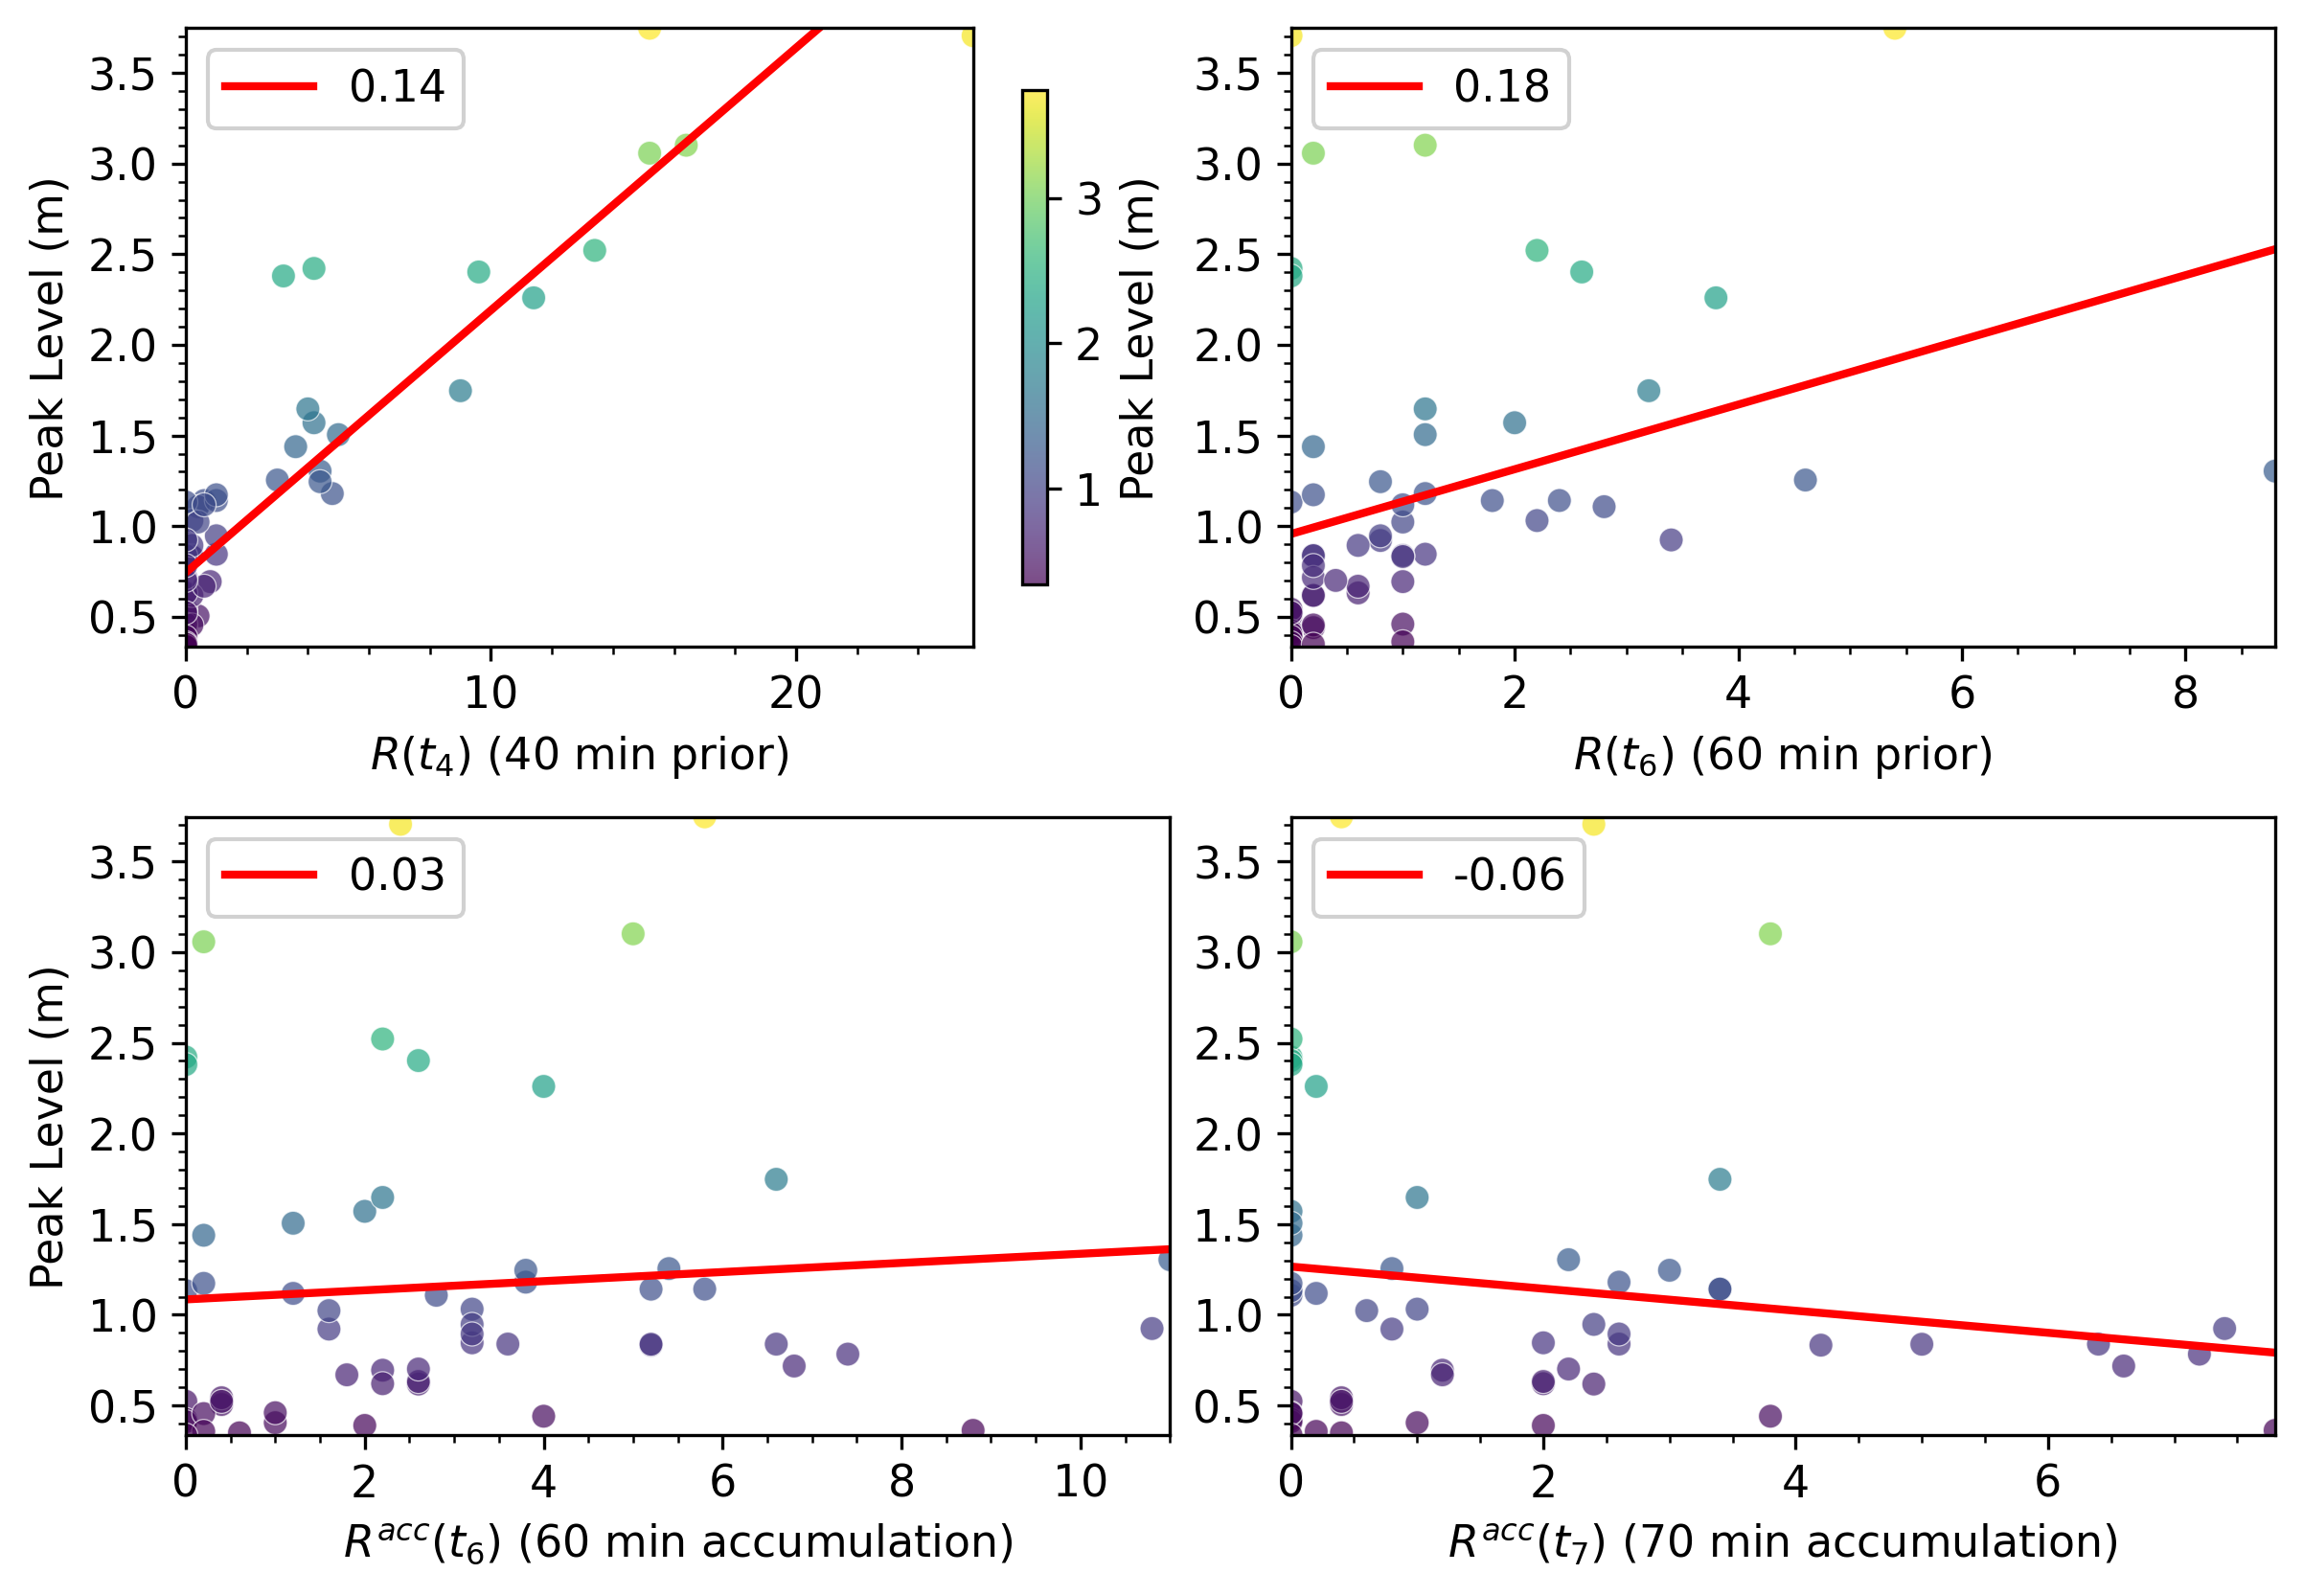

In [50]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from matplotlib.ticker import AutoMinorLocator

# Feature labels with clean LaTeX formatting
feature_labels = {
    'sil_40': r'$R(t_4)$ (40 min prior)',
    'sil_60': r'$R(t_6)$ (60 min prior)',
    'sil_accumulated_60': r'$R^{acc}(t_6)$ (60 min accumulation)',
    'sil_accumulated_70': r'$R^{acc}(t_7)$ (70 min accumulation)'
}

# Data preparation
X = df[lista_features_r2].values
y = df["global_peak"].values.reshape(-1, 1)

# Get global y-axis range for consistent scaling
y_min = y.min()
y_max = y.max()

# Plot setup
plt.figure(figsize=(8, 6), dpi=300)
plt.rcParams.update({'font.size': 11, 'font.family': 'DejaVu Sans'})

# Plot raw scatter + regression line per feature
for i, feature in enumerate(lista_features_r2):
    ax = plt.subplot(2, 2, i + 1)
    x = X[:, i].reshape(-1, 1)

    model = LinearRegression()
    model.fit(x, y)
    y_pred = model.predict(x)

    # Scatter using raw x
    sc = ax.scatter(x, y, c=y.flatten(), cmap='viridis', alpha=0.7,
                    edgecolor='w', linewidth=0.3, vmin=y_min, vmax=y_max)

    # Regression line using raw x range
    x_plot = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
    ax.plot(x_plot, model.predict(x_plot), 'r-', lw=2, label=f'{model.coef_[0][0]:.2f}')

    # Formatting
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel(feature_labels[feature])
    ax.set_ylabel('Peak Level (m)' if i % 2 == 0 else '')
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.legend(loc='upper left', framealpha=0.9)

    # Add colorbar to the first subplot only
    if i == 0:
        cbar = plt.colorbar(sc, ax=ax, shrink=0.8)
        cbar.set_label('Peak Level (m)')

# Final layout
plt.tight_layout()
plt.subplots_adjust(top=0.92)
# Optional: Add title
# plt.suptitle("Raw Correlations Between Rainfall Features and Peak Level", y=0.98)

# Save and show
plt.savefig("Raw_Correlations_Rainfall_Peak.png", dpi=300, bbox_inches='tight')
plt.show()


In [46]:
full_model.coef_

AttributeError: 'LinearRegression' object has no attribute 'coef'

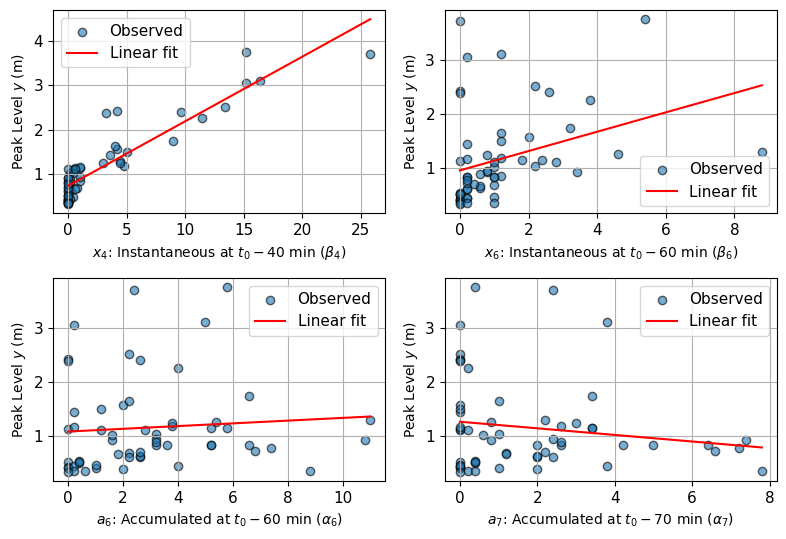

In [58]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Define feature names and labels
lista_features_r2 = ['sil_40', 'sil_60', 'sil_accumulated_60', 'sil_accumulated_70']
feature_labels = {
    'sil_40': r'$x_4$: Instantaneous at $t_0 - 40$ min ($\beta_4$)',
    'sil_60': r'$x_6$: Instantaneous at $t_0 - 60$ min ($\beta_6$)',
    'sil_accumulated_60': r'$a_6$: Accumulated at $t_0 - 60$ min ($\alpha_6$)',
    'sil_accumulated_70': r'$a_7$: Accumulated at $t_0 - 70$ min ($\alpha_7$)'
}

X = df[lista_features_r2]
y = df["global_peak"].values.reshape(-1, 1)

plt.figure(figsize=(8, 6))
for i, feature in enumerate(lista_features_r2):
    plt.subplot(2, 2, i+1)
    x_feat = X[feature].values.reshape(-1, 1)
    
    # Fit linear regression
    model = LinearRegression()
    model.fit(x_feat, y)
    y_pred = model.predict(x_feat)
    
    # Scatter plot
    plt.scatter(x_feat, y, alpha=0.6, edgecolor='k', label='Observed')
    
    # Plot regression line
    x_line = np.linspace(x_feat.min(), x_feat.max(), 100).reshape(-1, 1)
    y_line = model.predict(x_line)
    plt.plot(x_line, y_line, color='red', label='Linear fit')

    # Axis labels and title
    plt.xlabel(feature_labels[feature], fontsize=10)
    plt.ylabel(r'Peak Level $y$ (m)', fontsize=10)
  #  plt.title(f"Regression input: {feature}", fontsize=11)
    plt.grid(True)
    plt.legend()

#plt.suptitle("Selected Features and Linear Fits vs. Peak Level ($\hat{y}$)", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# Save the plot with 300 DPI
plt.show()
plt.savefig("Regresion.png", dpi=300)
plt.close()


In [40]:
odel = LinearRegression()
    model.fit(x_feat, y)
    y_pred = model.predict(x_feat)

array([[-0.060841]])

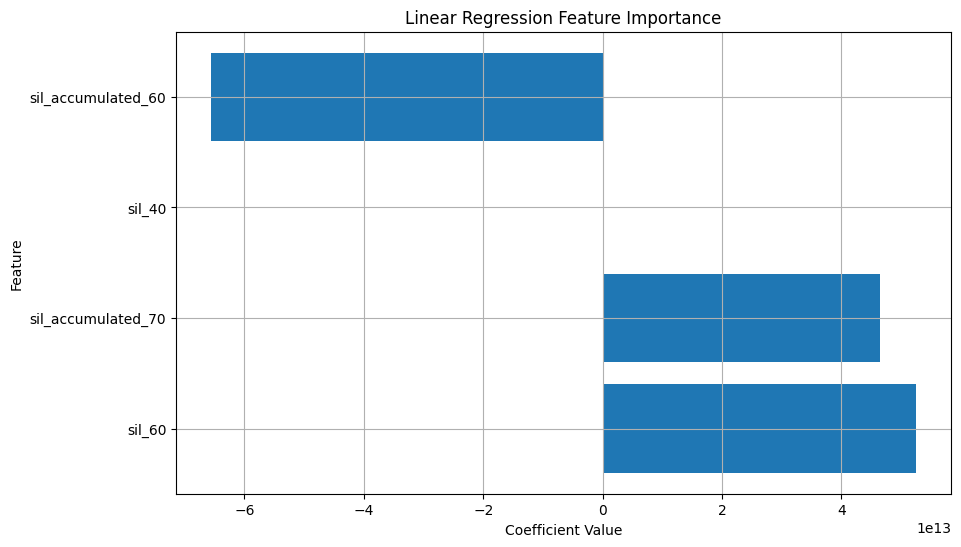

In [32]:
feature_importance = pd.DataFrame({
    'Feature': lista_features_r2,
    'Coefficient': model.coef_[0]
}).sort_values('Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'])
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title("Linear Regression Feature Importance")
plt.grid(True)
plt.show()

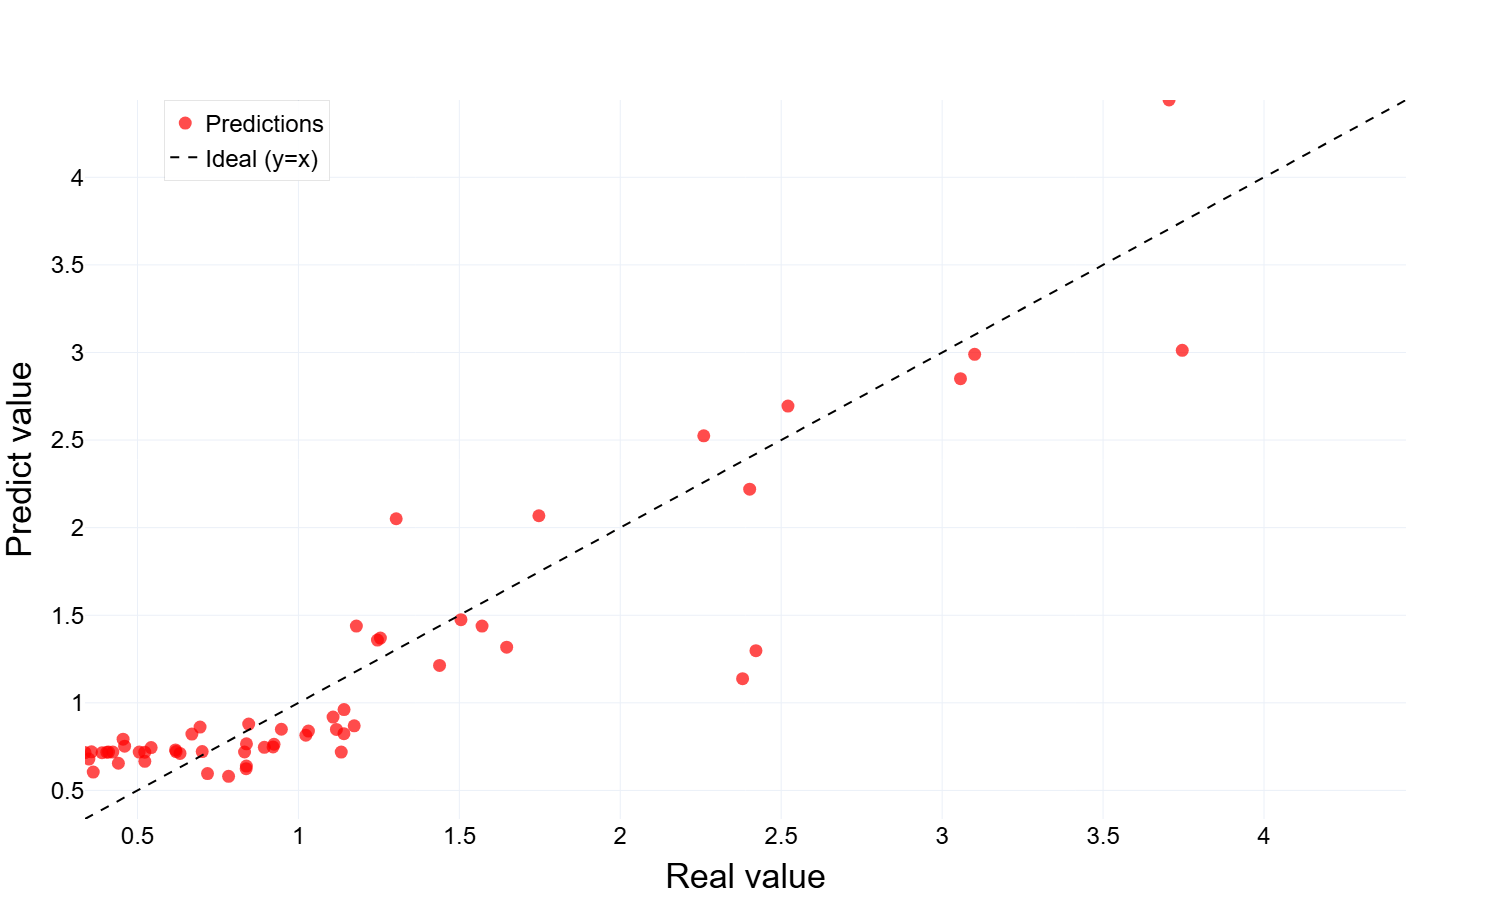

In [13]:
min_val = float(min(y_true.min(), y_pred.min()))
max_val = float(max(y_true.max(), y_pred.max()))

x_line = [min_val, max_val]
y_line = [min_val, max_val]

trace_pred_name = f"Predictions (W=3, R²={r2:.3f}, RMSE={rmse:.3f}, MAPE={mape:.3f})"

# Crear la figura
fig = go.Figure()

# Create the figure
fig = go.Figure()

# Add predictions
fig.add_trace(go.Scatter(
    x=y_true.flatten(),
    y=y_pred.flatten(),
    mode='markers',
    marker=dict(color='red', opacity=0.7, size=13),
    name="Predictions"
))

# Add ideal line (y=x)
fig.add_trace(go.Scatter(
    x=x_line,
    y=y_line,
    mode='lines',
    line=dict(dash='dash', color='black'),
    name="Ideal (y=x)"
))

# Update layout with legend in a box
fig.update_layout(
    xaxis_title="Real value",
    yaxis_title="Predict value",
    template="plotly_white",
    legend=dict(
        x=0.06,
        y=1,
        xanchor='left',
        yanchor='top',
        bgcolor='rgba(255, 255, 255, 0.9)',  # Fondo gris translúcido (ajusta el alpha)
        bordercolor='rgba(0, 0, 0, 0.1)',    # Borde semi-transparente
        borderwidth=1,
        font=dict(
            family="Arial",
            size=24,
            color="black"
        )
    ),
    width=900,
    height=900,
    plot_bgcolor='white',
    paper_bgcolor='white',
)

# Configure axes
fig.update_xaxes(
    range=[min_val, max_val],
    title_font=dict(size=34, family="Arial", color="black"),
    tickfont=dict(size=24, family="Arial", color="black")
)

fig.update_yaxes(
    range=[min_val, max_val],
    title_font=dict(size=34, family="Arial", color="black"),
    tickfont=dict(size=24, family="Arial", color="black")
)

fig.show()

## 3.2.2 LR model based the best RMSE metric 

In [12]:
X = df[lista_features_rmse]
y = df["global_peak"].values.reshape(-1, 1)
if len(y.shape) == 1:
    y = y.reshape(-1, 1)
scaler_X = MinMaxScaler()  
scaler_y = MinMaxScaler()
X_normalized = scaler_X.fit_transform(X)
y_normalized = scaler_y.fit_transform(y)
model = LinearRegression()
kf = KFold(n_splits=5, shuffle=True, random_state=42) 
y_pred_normalized = cross_val_predict(model, X_normalized, y_normalized, cv=kf)


y_pred = scaler_y.inverse_transform(y_pred_normalized)
y_true = scaler_y.inverse_transform(y_normalized)
r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = mean_absolute_percentage_error(y_true, y_pred)

print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f}")

R² Score: 0.8209
RMSE: 0.3509
MAPE: 0.3127


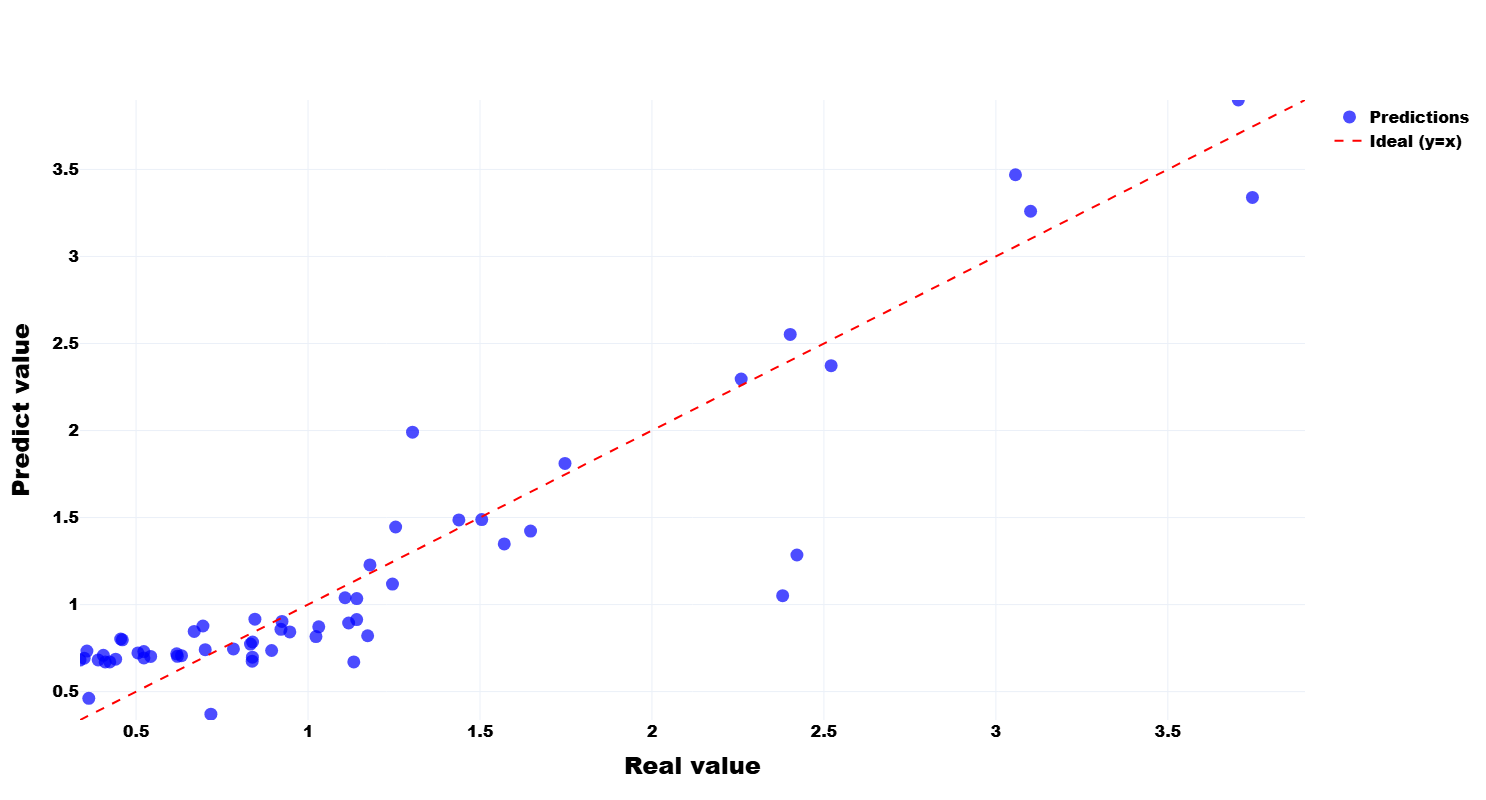

In [362]:
min_val = float(min(y_true.min(), y_pred.min()))
max_val = float(max(y_true.max(), y_pred.max()))

x_line = [min_val, max_val]
y_line = [min_val, max_val]

trace_pred_name = f"Predictions (W=3, R²={r2:.3f}, RMSE={rmse:.3f}, MAPE={mape:.3f})"

# Crear la figura
fig = go.Figure()

# Agregar las predicciones
fig.add_trace(go.Scatter(
    x=y_true.flatten(),
    y=y_pred.flatten(),
    mode='markers',
    marker=dict(color='blue', opacity=0.7,size=13),
    name="Predictions"
))

# Agregar la línea ideal (y=x)
fig.add_trace(go.Scatter(
    x=x_line,
    y=y_line,
    mode='lines',
    line=dict(dash='dash', color='red'),
    name="Ideal (y=x)"
))

# Actualizar el layout
fig.update_layout(
    xaxis_title="Real value",
    yaxis_title="Predict value",
    template="plotly_white",
    legend=dict(
        x=1.02, 
        y=1,
        font=dict(
            family="Arial Black",  # Fuente en negrita
            size=16,               # Tamaño del texto
            color="black"          # Color negro
        )
    ),
    
    width=1600,  # Establecer tamaño de la imagen en 1200x1200
    height=800,
    plot_bgcolor='white',
    paper_bgcolor='white',
)

# Configuración de los ejes x e y
fig.update_xaxes(
    range=[min_val, max_val],
    title_font=dict(size=24, family="Arial Black", color="black"),  # Negrita y color negro
    tickfont=dict(size=16, family="Arial Black", color="black", weight="bold")  # Negrita y color negro
)

fig.update_yaxes(
    range=[min_val, max_val],
    title_font=dict(size=24, family="Arial Black", color="black"),  # Negrita y color negro
    tickfont=dict(size=16, family="Arial Black", color="black", weight="bold")  # Negrita y color negro
)

fig.show()

## 3.2.3 LR model based the best MAPE metric 

In [363]:
X = df[lista_features_mape]
y = df["global_peak"].values.reshape(-1, 1)
if len(y.shape) == 1:
    y = y.reshape(-1, 1)
scaler_X = MinMaxScaler()  
scaler_y = MinMaxScaler()
X_normalized = scaler_X.fit_transform(X)
y_normalized = scaler_y.fit_transform(y)
model = LinearRegression()
kf = KFold(n_splits=5, shuffle=True, random_state=42) 
y_pred_normalized = cross_val_predict(model, X_normalized, y_normalized, cv=kf)


y_pred = scaler_y.inverse_transform(y_pred_normalized)
y_true = scaler_y.inverse_transform(y_normalized)
r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = mean_absolute_percentage_error(y_true, y_pred)

print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f}")

R² Score: 0.8193
RMSE: 0.3525
MAPE: 0.2693


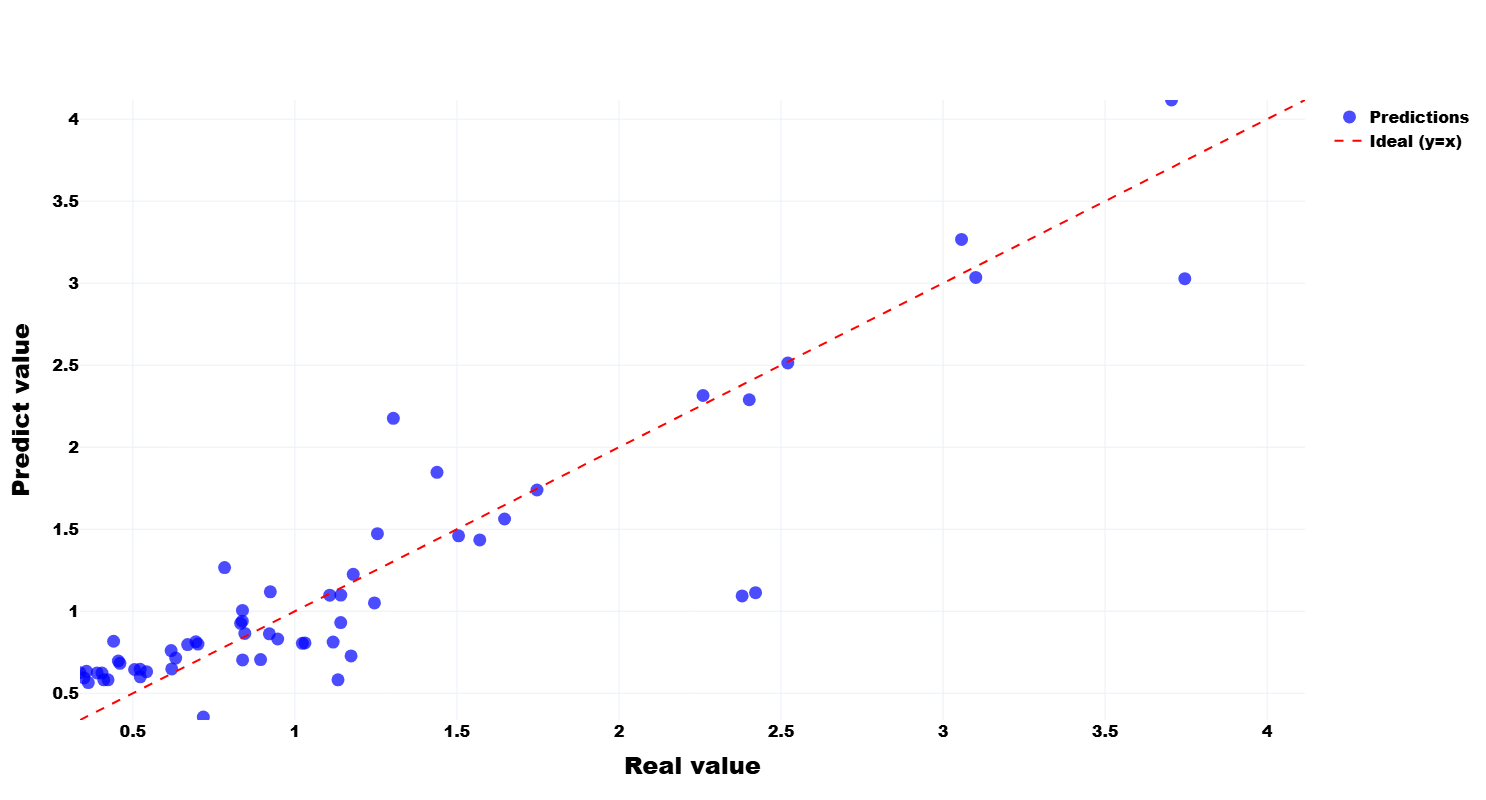

In [364]:
min_val = float(min(y_true.min(), y_pred.min()))
max_val = float(max(y_true.max(), y_pred.max()))

x_line = [min_val, max_val]
y_line = [min_val, max_val]

trace_pred_name = f"Predictions (W=3, R²={r2:.3f}, RMSE={rmse:.3f}, MAPE={mape:.3f})"

# Crear la figura
fig = go.Figure()

# Agregar las predicciones
fig.add_trace(go.Scatter(
    x=y_true.flatten(),
    y=y_pred.flatten(),
    mode='markers',
    marker=dict(color='blue', opacity=0.7,size=13),
    name="Predictions"
))

# Agregar la línea ideal (y=x)
fig.add_trace(go.Scatter(
    x=x_line,
    y=y_line,
    mode='lines',
    line=dict(dash='dash', color='red'),
    name="Ideal (y=x)"
))

# Actualizar el layout
fig.update_layout(
    xaxis_title="Real value",
    yaxis_title="Predict value",
    template="plotly_white",
    legend=dict(
        x=1.02, 
        y=1,
        font=dict(
            family="Arial Black",  # Fuente en negrita
            size=16,               # Tamaño del texto
            color="black"          # Color negro
        )
    ),
    
    width=1600,  # Establecer tamaño de la imagen en 1200x1200
    height=800,
    plot_bgcolor='white',
    paper_bgcolor='white',
)

# Configuración de los ejes x e y
fig.update_xaxes(
    range=[min_val, max_val],
    title_font=dict(size=24, family="Arial Black", color="black"),  # Negrita y color negro
    tickfont=dict(size=16, family="Arial Black", color="black", weight="bold")  # Negrita y color negro
)

fig.update_yaxes(
    range=[min_val, max_val],
    title_font=dict(size=24, family="Arial Black", color="black"),  # Negrita y color negro
    tickfont=dict(size=16, family="Arial Black", color="black", weight="bold")  # Negrita y color negro
)

fig.show()

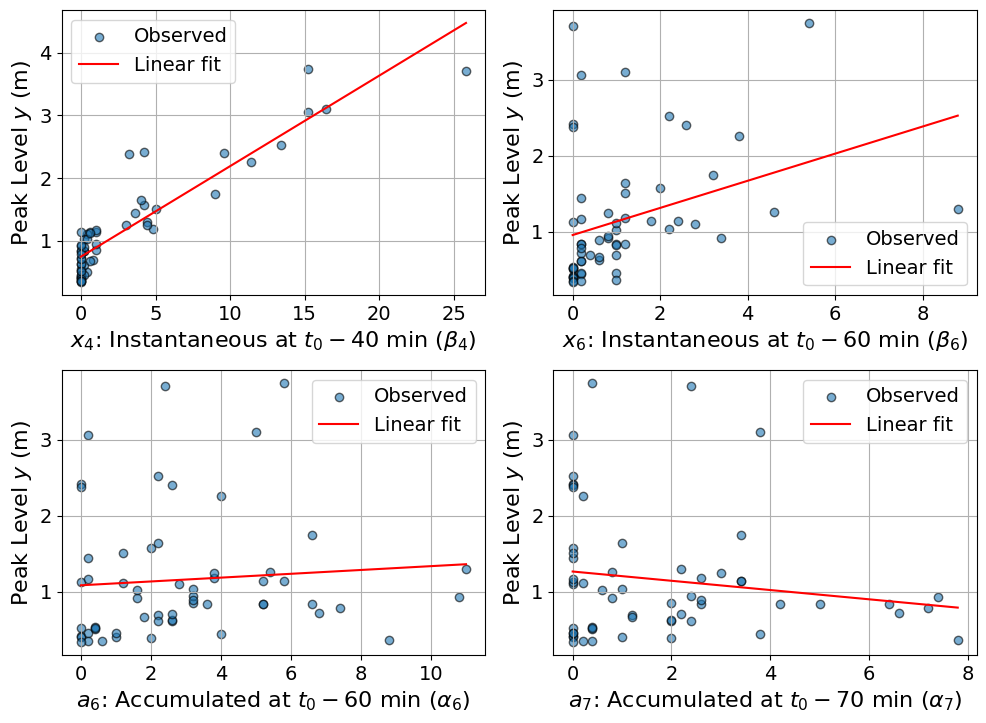

In [57]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Define feature names and labels
lista_features_r2 = ['sil_40', 'sil_60', 'sil_accumulated_60', 'sil_accumulated_70']
feature_labels = {
    'sil_40': r'$x_4$: Instantaneous at $t_0 - 40$ min ($\beta_4$)',
    'sil_60': r'$x_6$: Instantaneous at $t_0 - 60$ min ($\beta_6$)',
    'sil_accumulated_60': r'$a_6$: Accumulated at $t_0 - 60$ min ($\alpha_6$)',
    'sil_accumulated_70': r'$a_7$: Accumulated at $t_0 - 70$ min ($\alpha_7$)'
}

X = df[lista_features_r2]
y = df["global_peak"].values.reshape(-1, 1)

plt.figure(figsize=(10, 8))
for i, feature in enumerate(lista_features_r2):
    ax = plt.subplot(2, 2, i+1)
    x_feat = X[feature].values.reshape(-1, 1)
    
    # Fit linear regression
    model = LinearRegression()
    model.fit(x_feat, y)
    y_pred = model.predict(x_feat)
    
    # Scatter plot
    ax.scatter(x_feat, y, alpha=0.6, edgecolor='k', label='Observed')
    
    # Plot regression line
    x_line = np.linspace(x_feat.min(), x_feat.max(), 100).reshape(-1, 1)
    y_line = model.predict(x_line)
    ax.plot(x_line, y_line, color='red', label='Linear fit')

    # Axis labels with larger font
    ax.set_xlabel(feature_labels[feature], fontsize=16)
    ax.set_ylabel(r'Peak Level $y$ (m)', fontsize=16)
    
    # Increase tick label size
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    
    ax.grid(True)
    ax.legend(fontsize=14)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
plt.savefig("Regresion_v2.png", dpi=300)
plt.close()


In [59]:
plt.savefig("Regresion_v2.png", dpi=300)
plt.close()

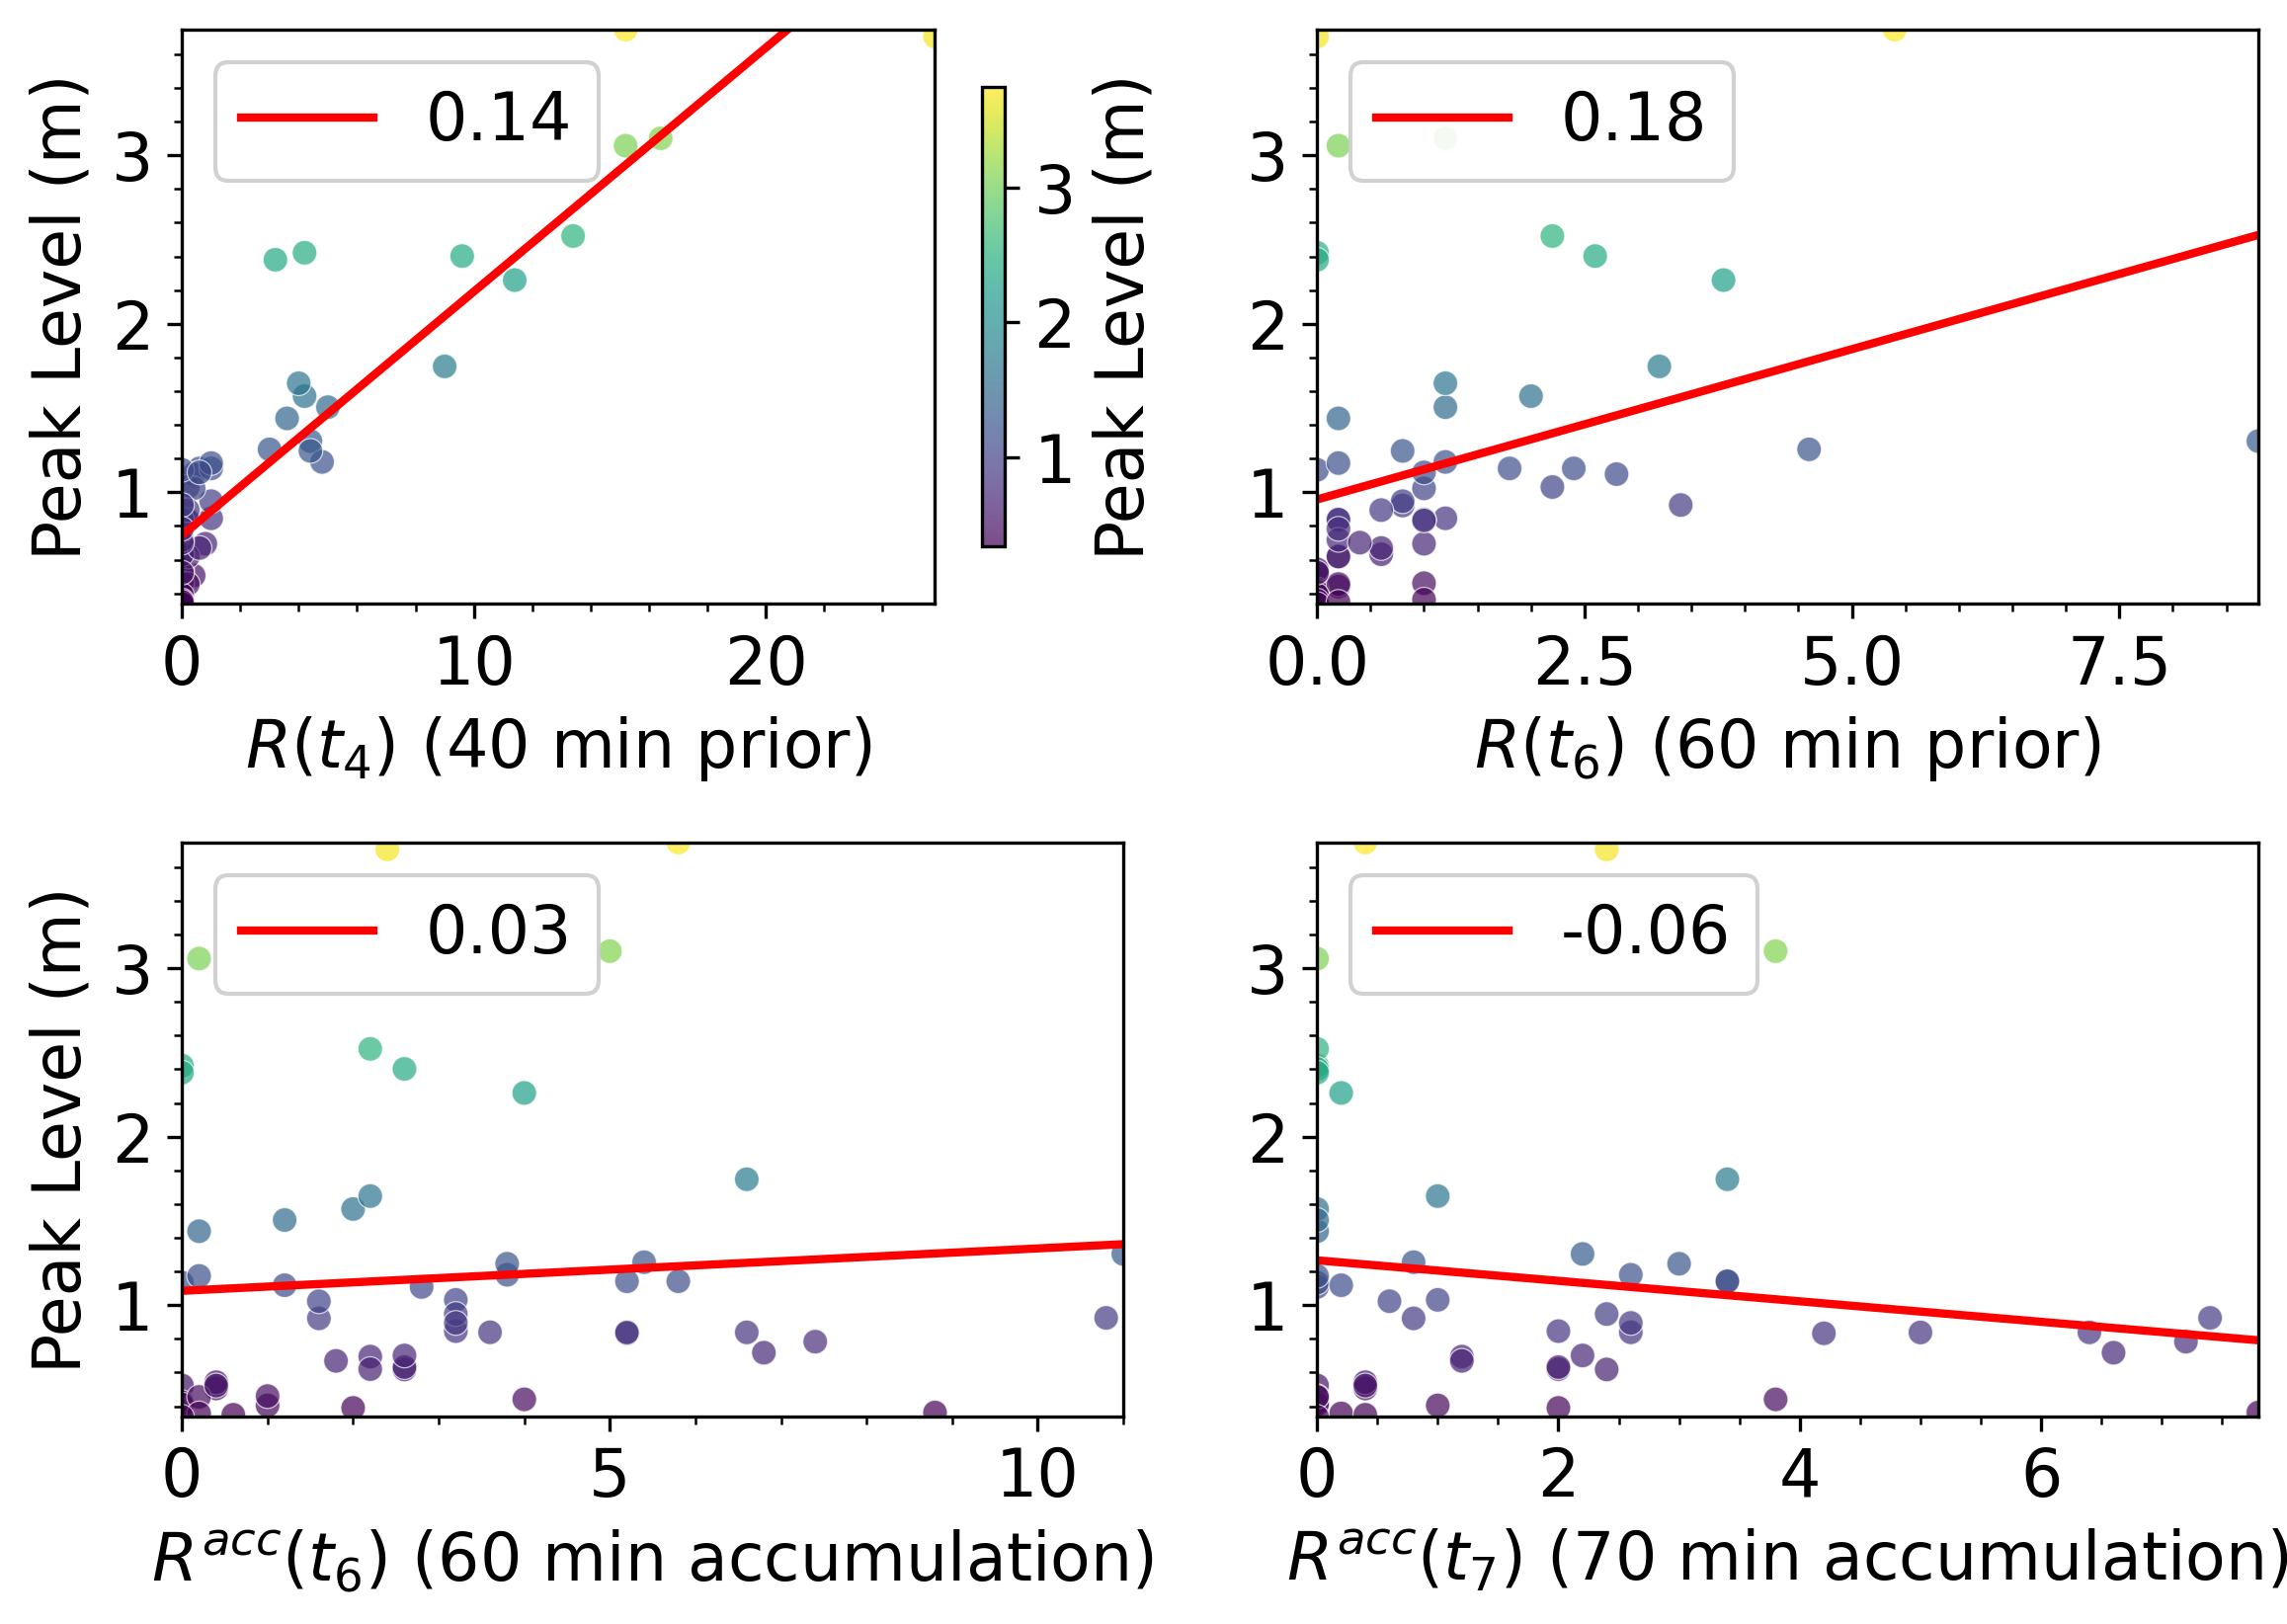

In [61]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from matplotlib.ticker import AutoMinorLocator

# Feature labels with clean LaTeX formatting
feature_labels = {
    'sil_40': r'$R(t_4)$ (40 min prior)',
    'sil_60': r'$R(t_6)$ (60 min prior)',
    'sil_accumulated_60': r'$R^{acc}(t_6)$ (60 min accumulation)',
    'sil_accumulated_70': r'$R^{acc}(t_7)$ (70 min accumulation)'
}

# Data preparation
X = df[lista_features_r2].values
y = df["global_peak"].values.reshape(-1, 1)

# Get global y-axis range for consistent scaling
y_min = y.min()
y_max = y.max()

# Plot setup
plt.figure(figsize=(8, 6), dpi=300)
plt.rcParams.update({'font.size': 16, 'font.family': 'DejaVu Sans'})

# Plot raw scatter + regression line per feature
for i, feature in enumerate(lista_features_r2):
    ax = plt.subplot(2, 2, i + 1)
    x = X[:, i].reshape(-1, 1)

    model = LinearRegression()
    model.fit(x, y)
    y_pred = model.predict(x)

    # Scatter using raw x
    sc = ax.scatter(x, y, c=y.flatten(), cmap='viridis', alpha=0.7,
                    edgecolor='w', linewidth=0.3, vmin=y_min, vmax=y_max)

    # Regression line using raw x range
    x_plot = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
    ax.plot(x_plot, model.predict(x_plot), 'r-', lw=2, label=f'{model.coef_[0][0]:.2f}')

    # Formatting
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel(feature_labels[feature])
    ax.set_ylabel('Peak Level (m)' if i % 2 == 0 else '')
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.legend(loc='upper left', framealpha=0.9)

    # Add colorbar to the first subplot only
    if i == 0:
        cbar = plt.colorbar(sc, ax=ax, shrink=0.8)
        cbar.set_label('Peak Level (m)')

# Final layout
plt.tight_layout()
plt.subplots_adjust(top=0.92)
# Optional: Add title
# plt.suptitle("Raw Correlations Between Rainfall Features and Peak Level", y=0.98)

# Save and show
plt.savefig("Raw_Correlations_Rainfall_Peak_v2.png", dpi=300, bbox_inches='tight')
plt.show()
